# Reimagining the primary process

## As the states to to vote on the Republican and Democratic nominee for president, there has been discussion about which state victories mean the most for a general election. This work goes into depth about the way in which states are assigned delegate numbers, and an analysis of the consequences of one alternative method.

### Configuration of plots.

In [75]:
import pandas as pd
import matplotlib

font = {'family' : 'monospace',
        'weight' : 'light',
        'size'   : 20}

matplotlib.rc('font', **font)

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

%matplotlib inline
plt.rcParams['savefig.dpi'] = 150
%reload_ext autoreload

google = ["#176ced", "#d9432f", "#ffb700", "#009a57", "#777777"]

### The current way states are assigned delegates are roughly proportional to their number of electoral votes. The Democratic Party assigns delegates in ratios that closely follow that of the electoral votes, while the Republican Party gives smaller states greater weight.

In [76]:
del_df = pd.read_csv('state_dels.csv', index_col=0)

norm_e = del_df['Electoral Votes'] / sum(del_df['Electoral Votes'])
norm_r = del_df['R Dels'] / sum(del_df['R Dels'])

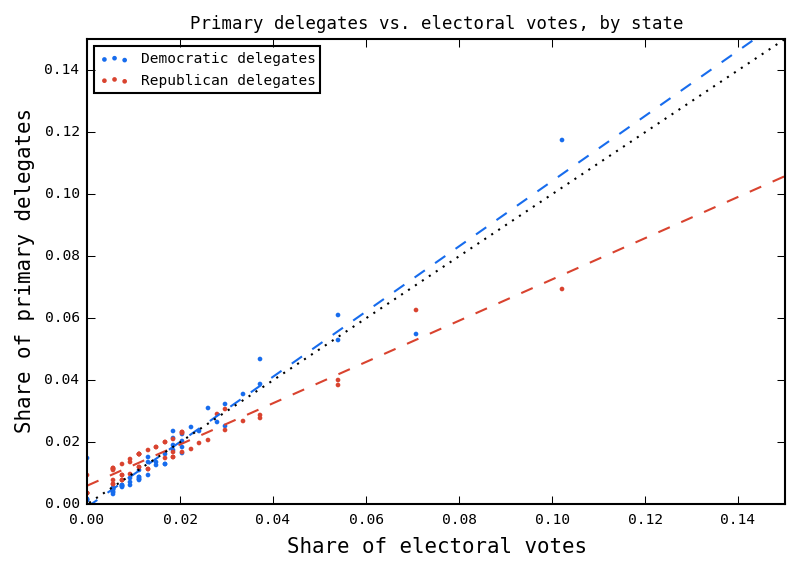

In [77]:
plt.scatter(norm_e, norm_d, c=google[0], lw=0, label='Democratic delegates', s=5)
p = np.poly1d(np.polyfit(norm_e, norm_d, 1))
xp = np.linspace(0, 1, 100)
plt.plot(xp, p(xp), ls = "--", color = google[0])

plt.scatter(norm_e, norm_r, c=google[1], lw=0, label='Republican delegates', s=5)
p = np.poly1d(np.polyfit(norm_e, norm_r, 1))
xp = np.linspace(0, 1, 100)
plt.plot(xp, p(xp), ls = "--", color = google[1])

plt.plot([-1, 1],[-1, 1], linestyle = ":", color = "k")

plt.legend(fontsize = "x-small", loc = 2)
plt.ylabel("Share of primary delegates")
plt.tick_params(labelsize = 7)
plt.xlabel("Share of electoral votes")
plt.xlim(0, .15)
plt.ylim(0, .15)
plt.title("Primary delegates vs. electoral votes, by state", fontsize = "small")
plt.show()

### Both parties assign delegates with some fluctuation around the electoral share line. For example: California, the largest state, is overrepresented in the Democratic Party process, but massively underrepresented in the Republican Party. We can explore the hypothesis that the parties are giving favor to states that vote their way by looking at their historical voting record.

### I will use the past four presidential elections as a measure of a state's bias. These elections make for a strong dataset for present biases. They involve two non-incumbent presidents and one incumbency from each party. In addition, there were very limited thrid party runs in these elections, so the proportion of voters for each party is well-represented.

### Looking at the average vote margin, we can confirm that each party gives more delegates to the states that vote their way. The Republican Party tilts the scale towards its favorable states a little more than the Democratic Party, but there is still some fluctuation around the trend line for both parties.

In [78]:
hist_df = pd.read_csv('state_histories.csv', index_col=0)

average_diff = np.average(hist_df.loc['Alabama':'Washington DC'], 1)
d_dem = norm_d.loc['Alabama':'Washington DC'] - norm_e.loc['Alabama':'Washington DC']
d_rep = norm_r.loc['Alabama':'Washington DC'] - norm_e.loc['Alabama':'Washington DC']

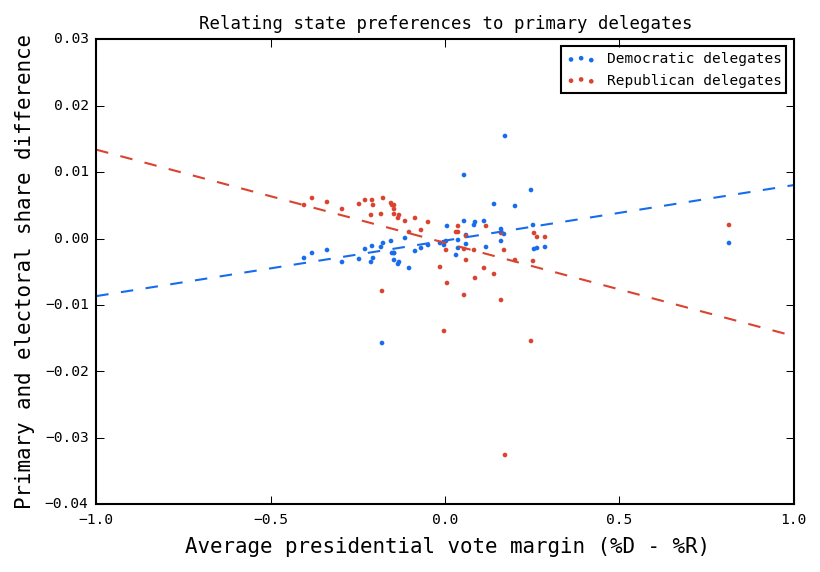

In [79]:
plt.scatter(average_diff, d_dem, c=google[0], lw=0, label='Democratic delegates', s=5)
p = np.poly1d(np.polyfit(average_diff, d_dem, 1))
xp = np.linspace(-1, 1, 100)
plt.plot(xp, p(xp), ls = "--", color = google[0])

plt.scatter(average_diff, d_rep, c=google[1], lw=0, label='Republican delegates', s=5)
p = np.poly1d(np.polyfit(average_diff, d_rep, 1))
xp = np.linspace(-1, 1, 100)
plt.plot(xp, p(xp), ls = "--", color = google[1])

plt.legend(fontsize = "x-small")
plt.ylabel("Primary and electoral share difference")
plt.tick_params(labelsize = 7)
plt.xlabel("Average presidential vote margin (%D - %R)")
plt.xlim(-1, 1)
plt.ylim(-.04, .03)
plt.title("Relating state preferences to primary delegates", fontsize = "small")
plt.show()

### One comment that has been made repeatedly over the course of this year's primaries is about how much a candidates support should count in states that vote heavily towards the opposing party (e.g. Clinton in Alabama or Trump in Massachusetts). 

### The logic behind this is that certain states are going to go to the same party in the general election no matter who the nominee is. Therefore, the parties should focus on finding candidates that are popular to voters in swing states, in the hope that those candidates will help deliver the swing states on election day.

### To determine a measure of a state's "swinginess", I used a states recent voting history combined with an assumption of a normal distribution of votes. From this I can generate an esitmate of how often a state will go to one party or the other. The swing factor is defined as the multiplication of the chance of going to each party. In this way, the states with the highest chance of going either way will be assigned the highest swing score. 

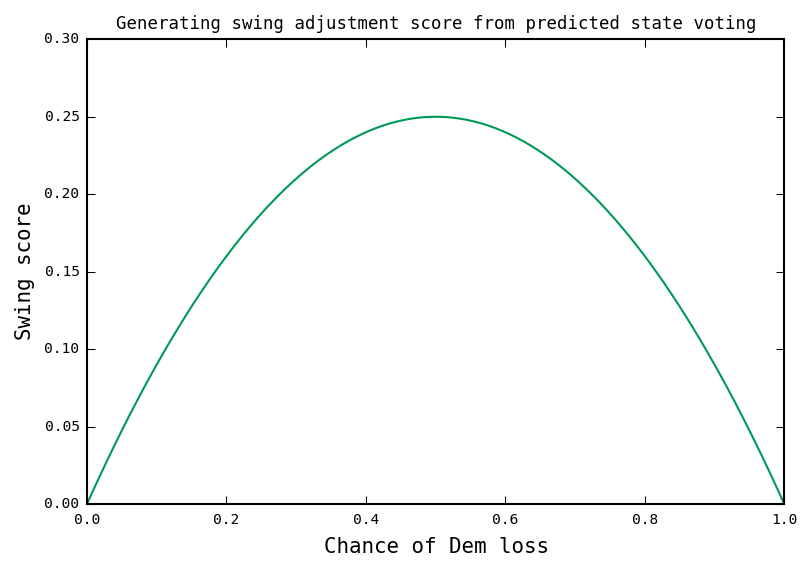

In [80]:
from scipy import stats

average_diff = np.average(hist_df.loc['Alabama':'Washington DC'], 1)
std_diff = np.std(hist_df.loc['Alabama':'Washington DC'], 1)

dem_lose_chance = stats.norm(average_diff, std_diff).cdf(0)
swing_score = dem_lose_chance * (1 - dem_lose_chance)

row_names = hist_df.loc['Alabama':'Washington DC'].index

plt.plot(np.linspace(0, 1, 100), [i * (1- i) for i in np.linspace(0, 1, 100)], color=google[3])
plt.ylabel("Swing score")
plt.tick_params(labelsize = 7)
plt.xlabel("Chance of Dem loss")
plt.xlim(0, 1)
plt.ylim(0, .3)
plt.title("Generating swing adjustment score from predicted state voting", fontsize = "small")
plt.show()

### Normalizing a state's electoral college share by swing score dramatically changes the landscape of the primary season. Florida immediately become the most important state to win, as it commands 25% of the total delegates. When Ohio, Virgina, and Colorado are added in, 60% of delegates are accounted for. Noteably, most of the Southern states lose all impact, along with Texas, California, New York, and Illinois.

In [81]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

swing_df = pd.DataFrame()
swing_df['Chance of Dem loss'] = dem_lose_chance
swing_df['Swing score'] = swing_score
swing_df['Swing-adjusted delegate share'] = (np.multiply(swing_df['Swing score'], 
                                                         norm_e.loc['Alabama':'Washington DC']) / \
                                             np.sum(np.multiply(swing_df['Swing score'], 
                                                                norm_e.loc['Alabama':'Washington DC'])))
swing_df = swing_df.set_index(row_names)
swing_df

,Chance of Dem loss,Swing score,Swing-adjusted delegate share
Alabama,1.000,0.000,0.000
Alaska,1.000,0.000,0.000
Arizona,1.000,0.000,0.000
Arkansas,0.977,0.023,0.005
California,0.004,0.004,0.007
Colorado,0.483,0.250,0.079
Connecticut,0.000,0.000,0.000
Delaware,0.006,0.006,0.001
Florida,0.545,0.248,0.253
Georgia,0.992,0.008,0.005


### Extrpolating this change to the current election, the Democratic contest narrows, as Clinton loses most of her delegates from the deep south and Sander's Colorado win becomes more powerful. Clinton's win in Virginia still keeps her ahead, though, 710 to 642.

In [82]:
dem_df = pd.DataFrame()
dem_df['Adjusted delegates'] = swing_df['Swing-adjusted delegate share'] * sum(del_df['D Dels'])
dem_df['Change in delegates'] = dem_df['Adjusted delegates'] -  del_df['D Dels']

dvotes_df = pd.read_csv('dem_votes.csv', index_col=0)
dem_df['Adjusted Clinton delegates'] = np.multiply(dem_df['Adjusted delegates'], 
                                                   dvotes_df.loc['Alabama':'Washington DC']['Clinton'])
dem_df['Adjusted Sanders delegates'] = np.multiply(dem_df['Adjusted delegates'], 
                                                   dvotes_df.loc['Alabama':'Washington DC']['Sanders'])

dem_df = dem_df.set_index(row_names)
dem_df

,Adjusted delegates,Change in delegates,Adjusted Clinton delegates,Adjusted Sanders delegates
Alabama,0.000,-53.000,0.000,0.000
Alaska,0.041,-15.959,nan,nan
Arizona,0.000,-75.000,nan,nan
Arkansas,19.361,-12.639,12.836,5.750
California,28.827,-446.173,nan,nan
Colorado,318.798,252.798,128.794,187.772
Connecticut,0.037,-54.963,nan,nan
Delaware,2.701,-18.299,nan,nan
Florida,1020.117,806.117,nan,nan
Georgia,18.352,-83.648,13.085,5.175


In [83]:
print(np.nansum(dem_df['Adjusted Clinton delegates']))
print(np.nansum(dem_df['Adjusted Sanders delegates']))

710.356859971
642.207663315


### Similarly, in the Republican contest,  Trump loses delegates in the deep south, and Cruz loses delegates in Texas. Rubio vaults into 2nd place with a strong showing. The current breakdown is: 229 - Trump, 134 - Cruz, 163 - Rubio, 59 - Kasich.

In [84]:
rep_df = pd.DataFrame()
rep_df['Adjusted delegates'] = swing_df['Swing-adjusted delegate share'] * sum(del_df['R Dels'])
rep_df['Change in delegates'] = rep_df['Adjusted delegates'] -  del_df['R Dels']

rvotes_df = pd.read_csv('rep_votes.csv', index_col=0)
rep_df['Adjusted Trump delegates'] = np.multiply(rep_df['Adjusted delegates'], 
                                                   rvotes_df.loc['Alabama':'Washington DC']['Trump'])
rep_df['Adjusted Cruz delegates'] = np.multiply(rep_df['Adjusted delegates'], 
                                                   rvotes_df.loc['Alabama':'Washington DC']['Cruz'])
rep_df['Adjusted Rubio delegates'] = np.multiply(rep_df['Adjusted delegates'], 
                                                   rvotes_df.loc['Alabama':'Washington DC']['Rubio'])
rep_df['Adjusted Kasich delegates'] = np.multiply(rep_df['Adjusted delegates'], 
                                                   rvotes_df.loc['Alabama':'Washington DC']['Kasich'])

rep_df = rep_df.set_index(row_names)
rep_df

,Adjusted delegates,Change in delegates,Adjusted Trump delegates,Adjusted Cruz delegates,Adjusted Rubio delegates,Adjusted Kasich delegates
Alabama,0.000,-50.000,0.000,0.000,0.000,0.000
Alaska,0.025,-27.975,0.008,0.009,0.004,0.001
Arizona,0.000,-58.000,nan,nan,nan,nan
Arkansas,11.853,-28.147,3.888,3.615,2.951,0.439
California,17.648,-154.352,nan,nan,nan,nan
Colorado,195.163,158.163,nan,nan,nan,nan
Connecticut,0.023,-27.977,nan,nan,nan,nan
Delaware,1.653,-14.347,nan,nan,nan,nan
Florida,624.499,525.499,nan,nan,nan,nan
Georgia,11.235,-64.765,4.359,2.651,2.741,0.629


In [85]:
print(np.nansum(rep_df['Adjusted Trump delegates']))
print(np.nansum(rep_df['Adjusted Cruz delegates']))
print(np.nansum(rep_df['Adjusted Rubio delegates']))
print(np.nansum(rep_df['Adjusted Kasich delegates']))

229.332790482
133.982043168
162.609073673
58.7603918683


## Final thoughts

### While changing to a swing-weighted system might make sense on a strategic level, there are definite drawbacks to this plan on a idealogical level. Giving power to swing states will probably generate candidates that are more moderate, and might not be in line with the majority of the party. In addition, it takes away what little power voters in deeply red or deeply blue states have over choosing the president. Finally, it basically give Florida the power to choose the president, and I don't think that would make a lot of people confortable.

### For those wondering how exactly the delegates are calculated for each party, the rules can be found at thegreenpapers.com.